In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
np.set_printoptions(precision = 4)

In [112]:
import numpy as np
import scipy.stats
S = 2000
N = 2
mu = [0, 1]
sigma = [3, 10]
prior = [0.1, 0.9];
pdfs = [scipy.stats.norm(loc = m, scale = s) for m,s in zip(mu, sigma)]
st = np.vstack((mu, sigma, prior))
posts = np.zeros((S,N))
ents = np.zeros((S,1))
for s in range(S):
    mode = np.random.choice(N, p = prior)
    obs = st[0, mode] + st[1, mode]*np.random.randn(1)
    post = [st[2,i]*pdfs[i].pdf(obs) for i in range(N)]
    post = post/np.sum(post)
    posts[s,:] = np.squeeze(post)
    ents[s] = ent(np.squeeze(post))
print(posts)
print(ents)
post = np.mean(posts, axis = 0)
print('Prior: {}, Entropy: {}'.format(prior, ent(prior)))
print('Post:  {}, Entropy: {}'.format(post, np.mean(ents)))#ent(post)))
print('Gain:  {}'.format(ent(prior)-np.mean(ents)))
print('Exp gain: {}'.format(inf_gain(prior, mu, sigma)))

[[2.10088832e-01 7.89911168e-01]
 [1.62224755e-04 9.99837775e-01]
 [9.97406284e-02 9.00259372e-01]
 ...
 [1.78395167e-01 8.21604833e-01]
 [3.39194494e-02 9.66080551e-01]
 [3.70116171e-03 9.96298838e-01]]
[[0.51407434]
 [0.00157787]
 [0.3245127 ]
 ...
 [0.46895126]
 [0.14811307]
 [0.02441751]]
Prior: [0.1, 0.9], Entropy: 0.3250829733914482
Post:  [0.10248532 0.89751468], Entropy: 0.2633840372837665
Gain:  0.06169893610768168


NameError: name 'pi' is not defined

In [2]:
import casadi as ca
import numpy as np
def ent(b):
    return np.sum([-w*np.log(w) for w in b])

def inf_gain_np(b, mu, sigma):
    D = 1.
    ub = 0
    for n in range(len(b)):
        ln_arg = [b[m]*(2*np.pi)**(-D/2)*(sigma[n]+sigma[m])**(-0.5)\
                  *np.exp(-0.5*(mu[n]-mu[m])\
                          /(sigma[m]+sigma[n])\
                          *(mu[n]-mu[m])) for m in range(len(b))]
        ub += b[n]*(np.log(np.sum(ln_arg))\
            +D/2*(np.log(2*np.pi)+1)\
            +0.5*np.log((sigma[n])))
    #print('ub: {}'.format(-ub))
    return -ub

def inf_gain(b, mu, sigma):
    D = 1
    ub = 0.0
    for n in range(len(b)):
        ln_arg = [b[m]*(2*np.pi)**(-D/2)*(sigma[n]+sigma[m])**(-0.5)\
                  *ca.exp(-0.5*(mu[n]-mu[m])\
                          /(sigma[m]+sigma[n])\
                          *(mu[n]-mu[m])) for m in range(len(b))]
        #print(ca.log(ca.sum1(ca.vertcat(*ln_arg))))
        ub += b[n]*(ca.log(ca.sum1(ca.vertcat(*ln_arg)))\
            +D/2*(ca.log(2*np.pi)+1)\
            +0.5*ca.log((sigma[n])))
    return -ub



In [4]:
### Testing Jacobian
mu = ca.MX.sym('mu1')
ig = inf_gain([0.25, 0.75], [mu, 1], [1, 15])
print(ig)
ig_jac = ca.Function('jacy',[mu], [ca.jacobian(ig, mu)])


(-((0.25*(1.41894+log(mac(ones(1x2),vertcat(0.0705237, (0.0748017*exp((((-0.5*(mu1-1))/16)*(mu1-1))))),0))))+(0.75*(1.35403+(1.41894+log(mac(ones(1x2),vertcat((0.0249339*exp((((-0.5*(1-mu1))/16)*(1-mu1)))), 0.0546274),0)))))))


In [25]:
### Testing a simple systemerino:
q = ca.MX.sym('q')
k1 = ca.MX.sym('k1')
m2 = ca.MX.sym('m2')
b2 = ca.MX.sym('b2')
k2 = ca.MX.sym('k2')
p = [q, k1, m2, b2, k2]
sigma_f = 1.0
sigma_w = 0.1*np.eye(2)
sigma_q = 0.5

# Fully observed
mu = [0, k1*q]
sigma_full = [sigma_f, sigma_f]
b = [0.5, 0.5]
ig = inf_gain(b, mu, sigma)
ig_f = ca.Function('ig', p, [ig])
ig_jac = ca.Function('ig_jac', p, [ca.jacobian(ig, ca.vertcat(*p))])
print('IG jacobian, Fully Obs: {}'.format(ig_jac(1, 10, 10, 1, 1)))

IG jacobian, Fully Obs: [[0.402371, 0.00457206, 00, 00, 00]]


In [23]:
# Fully + Partially observed info gain
from riccati_solver import RiccatiSolver
q = ca.MX.sym('q')
k1 = ca.MX.sym('k1')
m2 = ca.MX.sym('m2')
b2 = ca.MX.sym('b2')
k2 = ca.MX.sym('k2')
p = [q, k1, m2, b2, k2]
dt = 0.001
sigma_f = 2.0
sigma_w = np.array([[0, 0],[0, 2.0]])

mu = [0, k1*q]
sigma_fu = [sigma_f, sigma_f]
b = [0.5, 0.5]
ig_fu = inf_gain(b, mu, sigma_fu)
ig_fu_f = ca.Function('ig', p, [ig_fu])
ig_fu_jac = ca.Function('ig_jac', p, [ca.jacobian(ig_fu, ca.vertcat(*p))])


A = ca.MX.zeros(2,2)
A[0,0] = 1
A[0,1] = dt
A[1,0] = -k2/m2*dt
A[1,1] = 1-b2/m2*dt
C = ca.MX.zeros(1,2)
C[0,0] = k1
are_solv = RiccatiSolver('ric', 2,1)
P = are_solv(A.T, C.T, sigma_w/m2, sigma_f)

mu_pa = [0, k1*q]
#pos_unc = ca.Function('pos',p, [P[0,0]])
#pos_unc_jac = ca.Function('pos_unc', p, [ca.jacobian(P[0,0], ca.vertcat(*p))])
#print('Pos unc    : {}'.format(pos_unc(*p0)))
#print('Pos unc jac: {}'.format(pos_unc_jac(*p0)))

sigma_pa = [sigma_f, sigma_f+k1**2*P[0,0]]
b = [0.5, 0.5]
ig_pa = inf_gain(b, mu, sigma_pa)
ig_pa_f = ca.Function('ig', p, [ig_pa])
ig_pa_jac = ca.Function('ig_jac', p, [ca.jacobian(ig_pa, ca.vertcat(*p))])

In [24]:
#      q    k1   m2  b2  k2
p0 = [0.001, 5e3, 5, 10, 400]

print('IG    , Full Obs:  {}'.format(ig_fu_f(*p0)))
print('IG    , Part Obs:  {}'.format(ig_pa_f(*p0)))
print('Params: {}'.format([pn.name() for pn in p]))
print('IG jac, Full Obs:  {}'.format(ig_fu_jac(*p0)))
print('IG jac, Part Obs:  {}'.format(ig_pa_jac(*p0)))

IG    , Full Obs:  0.496722
IG    , Part Obs:  0.154291
Params: ['q', 'k1', 'm2', 'b2', 'k2']
IG jac, Full Obs:  [[263.048, 5.26097e-05, 00, 00, 00]]
IG jac, Part Obs:  [[368.685, 4.16543e-05, 0.0160203, 1.05737e-05, -2.16126e-09]]


'q'

In [19]:
### Testing Kalman calc
import numpy as np
import casadi as ca
from scipy.linalg import solve_discrete_are, eig
from riccati_solver import RiccatiSolver
print(solve_discrete_are(np.array([[1, 0.1],[-0.0, 0.2]]).T, np.array([[1], [0]]), 0.1*np.eye(2), 0.5))
are_solv = RiccatiSolver('ric', 2,1)
A = ca.MX.eye(2)
A[1,0] = 
P = are_solv(A, np.array([[1], [0]]).T, 0.1*np.eye(2), 0.5)
P_jac = ca.Function('P_jac',[k1], [ca.jacobian(P, k1)])
P_jac(1.0)

[[0.28141479 0.0023889 ]
 [0.0023889  0.10416636]]

[[1, 0], 
 [1, 1]]
[1, 0]
(2, 1)

[[0.1, 0], 
 [0, 0.1]]
0.5

[[0.937004, 0.379078], 
 [0.379078, 0.34718]]
(2, 2)

[[1, 0], 
 [1, 1]]
[1, 0]
(2, 1)

[[0.1, 0], 
 [0, 0.1]]
0.5

[[0.937004, 0.379078], 
 [0.379078, 0.34718]]
(2, 2)

[[1, 0], 
 [1, 1]]
[1, 0]
(2, 1)

[[0.1, 0], 
 [0, 0.1]]
0.5

[[0.937004, 0.379078], 
 [0.379078, 0.34718]]
(2, 2)

[[1, 0], 
 [1, 1]]
[1, 0]
(2, 1)

[[0.1, 0], 
 [0, 0.1]]
0.5

[[0.937004, 0.379078], 
 [0.379078, 0.34718]]
(2, 2)


DM([0.644418, 0.084998, 0.084998, -0.132607])

<IPython.core.display.Javascript object>


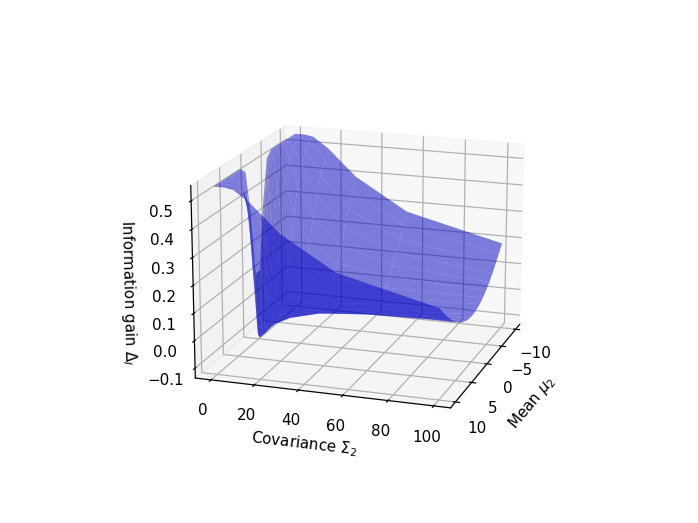

In [273]:
### plotting info gain for two gaussians
### generate info_gain_demo.png

grid_size = 20
k1_grid = np.linspace(-10, 10, num = grid_size)
k2_grid = np.logspace(-3, 2, num = grid_size)  
perf = np.zeros((grid_size, grid_size))
    
i = 0
for k1 in k1_grid:
    j = 0
    for k2 in k2_grid:                        
        perf[i,j] = inf_gain([0.5, 0.5], [0, k1], [1, k2])                
        j += 1
    i += 1

%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure()
ax = fig.gca(projection='3d')

k11, k22 = np.meshgrid(k1_grid, k2_grid)

# Plot the surface.
surf1 = ax.plot_surface(k11, k22, perf.T, color=[0,0,1,0.5],
                       linewidth=0.75, antialiased=True)#, label='Information gain')
surf1._facecolors2d=surf1._facecolors3d
surf1._edgecolors2d=surf1._edgecolors3d
#   surf2 = ax.plot_surface(k11, k22, DI, color=[1,0,0,0.5],
#                          linewidth=0.5, antialiased=True, label='Directed Information')
#   surf2._facecolors2d=surf2._facecolors3d
#   surf2._edgecolors2d=surf2._edgecolors3d
ax.set_xlabel('Mean $\mu_2$')
ax.set_ylabel('Covariance $\Sigma_2$')
ax.set_zlabel('Information gain $\Delta_I$')
#ax.legend()

plt.show()
#plt.savefig('info_gain_demo.png')